In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score

In [2]:
import warnings
warnings.simplefilter("ignore")

## Importar archivos de datos con los que se va a trabajar

In [3]:
wine = load_wine(as_frame=True)
description = wine['DESCR']
X = wine['data']
y = wine['target'].to_frame()
df = pd.concat([X,y],axis=1)
feature_names = wine['feature_names']
print(description)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

In [4]:
feature_names[-2] = 'od280/od315'
df.rename(columns = {df.columns[-3]:feature_names[-2]}, inplace = True)
X.rename(columns = {X.columns[-2]:feature_names[-2]}, inplace = True)

## Análisis Preeliminar Dataset

In [5]:
def BoxPlot(df,name,aspect={'left':0.2,'right':0.98,'bottom':0.2,'top':0.98,'wspace':0.9,'hspace':0.5},ancho=13,alto=26,labelsize=12,ticksize=12):
    fig = plt.figure(figsize=(ancho/2.54,alto/2.54))
    fig.subplots_adjust(**aspect)
    gs = plt.GridSpec(5, 3)
    ax = []
    for i in range(4):
        for j in range(3):
            ax.append(fig.add_subplot(gs[i,j]))
    ax.append(fig.add_subplot(gs[4,1]))
    for i,col in enumerate(feature_names):
        sns.boxplot(data=df, x='target',y=col,ax=ax[i])
        ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
        ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.f'))
        ax[i].yaxis.label.set_size(labelsize)
        ax[i].xaxis.label.set_size(labelsize)
    plt.savefig(name)
    plt.show()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   alcohol               178 non-null    float64
 1   malic_acid            178 non-null    float64
 2   ash                   178 non-null    float64
 3   alcalinity_of_ash     178 non-null    float64
 4   magnesium             178 non-null    float64
 5   total_phenols         178 non-null    float64
 6   flavanoids            178 non-null    float64
 7   nonflavanoid_phenols  178 non-null    float64
 8   proanthocyanins       178 non-null    float64
 9   color_intensity       178 non-null    float64
 10  hue                   178 non-null    float64
 11  od280/od315           178 non-null    float64
 12  proline               178 non-null    float64
 13  target                178 non-null    int32  
dtypes: float64(13), int32(1)
memory usage: 18.9 KB


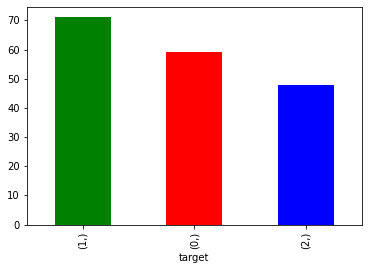

In [7]:
y.value_counts().plot.bar(color=['green', 'red', 'blue'])
y.value_counts(normalize=True)
plt.savefig('Target_imbalance.pdf')

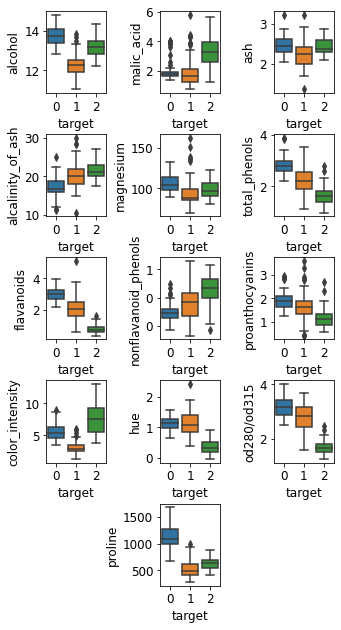

In [8]:
name='Boxplot_1.pdf'
BoxPlot(df,name)

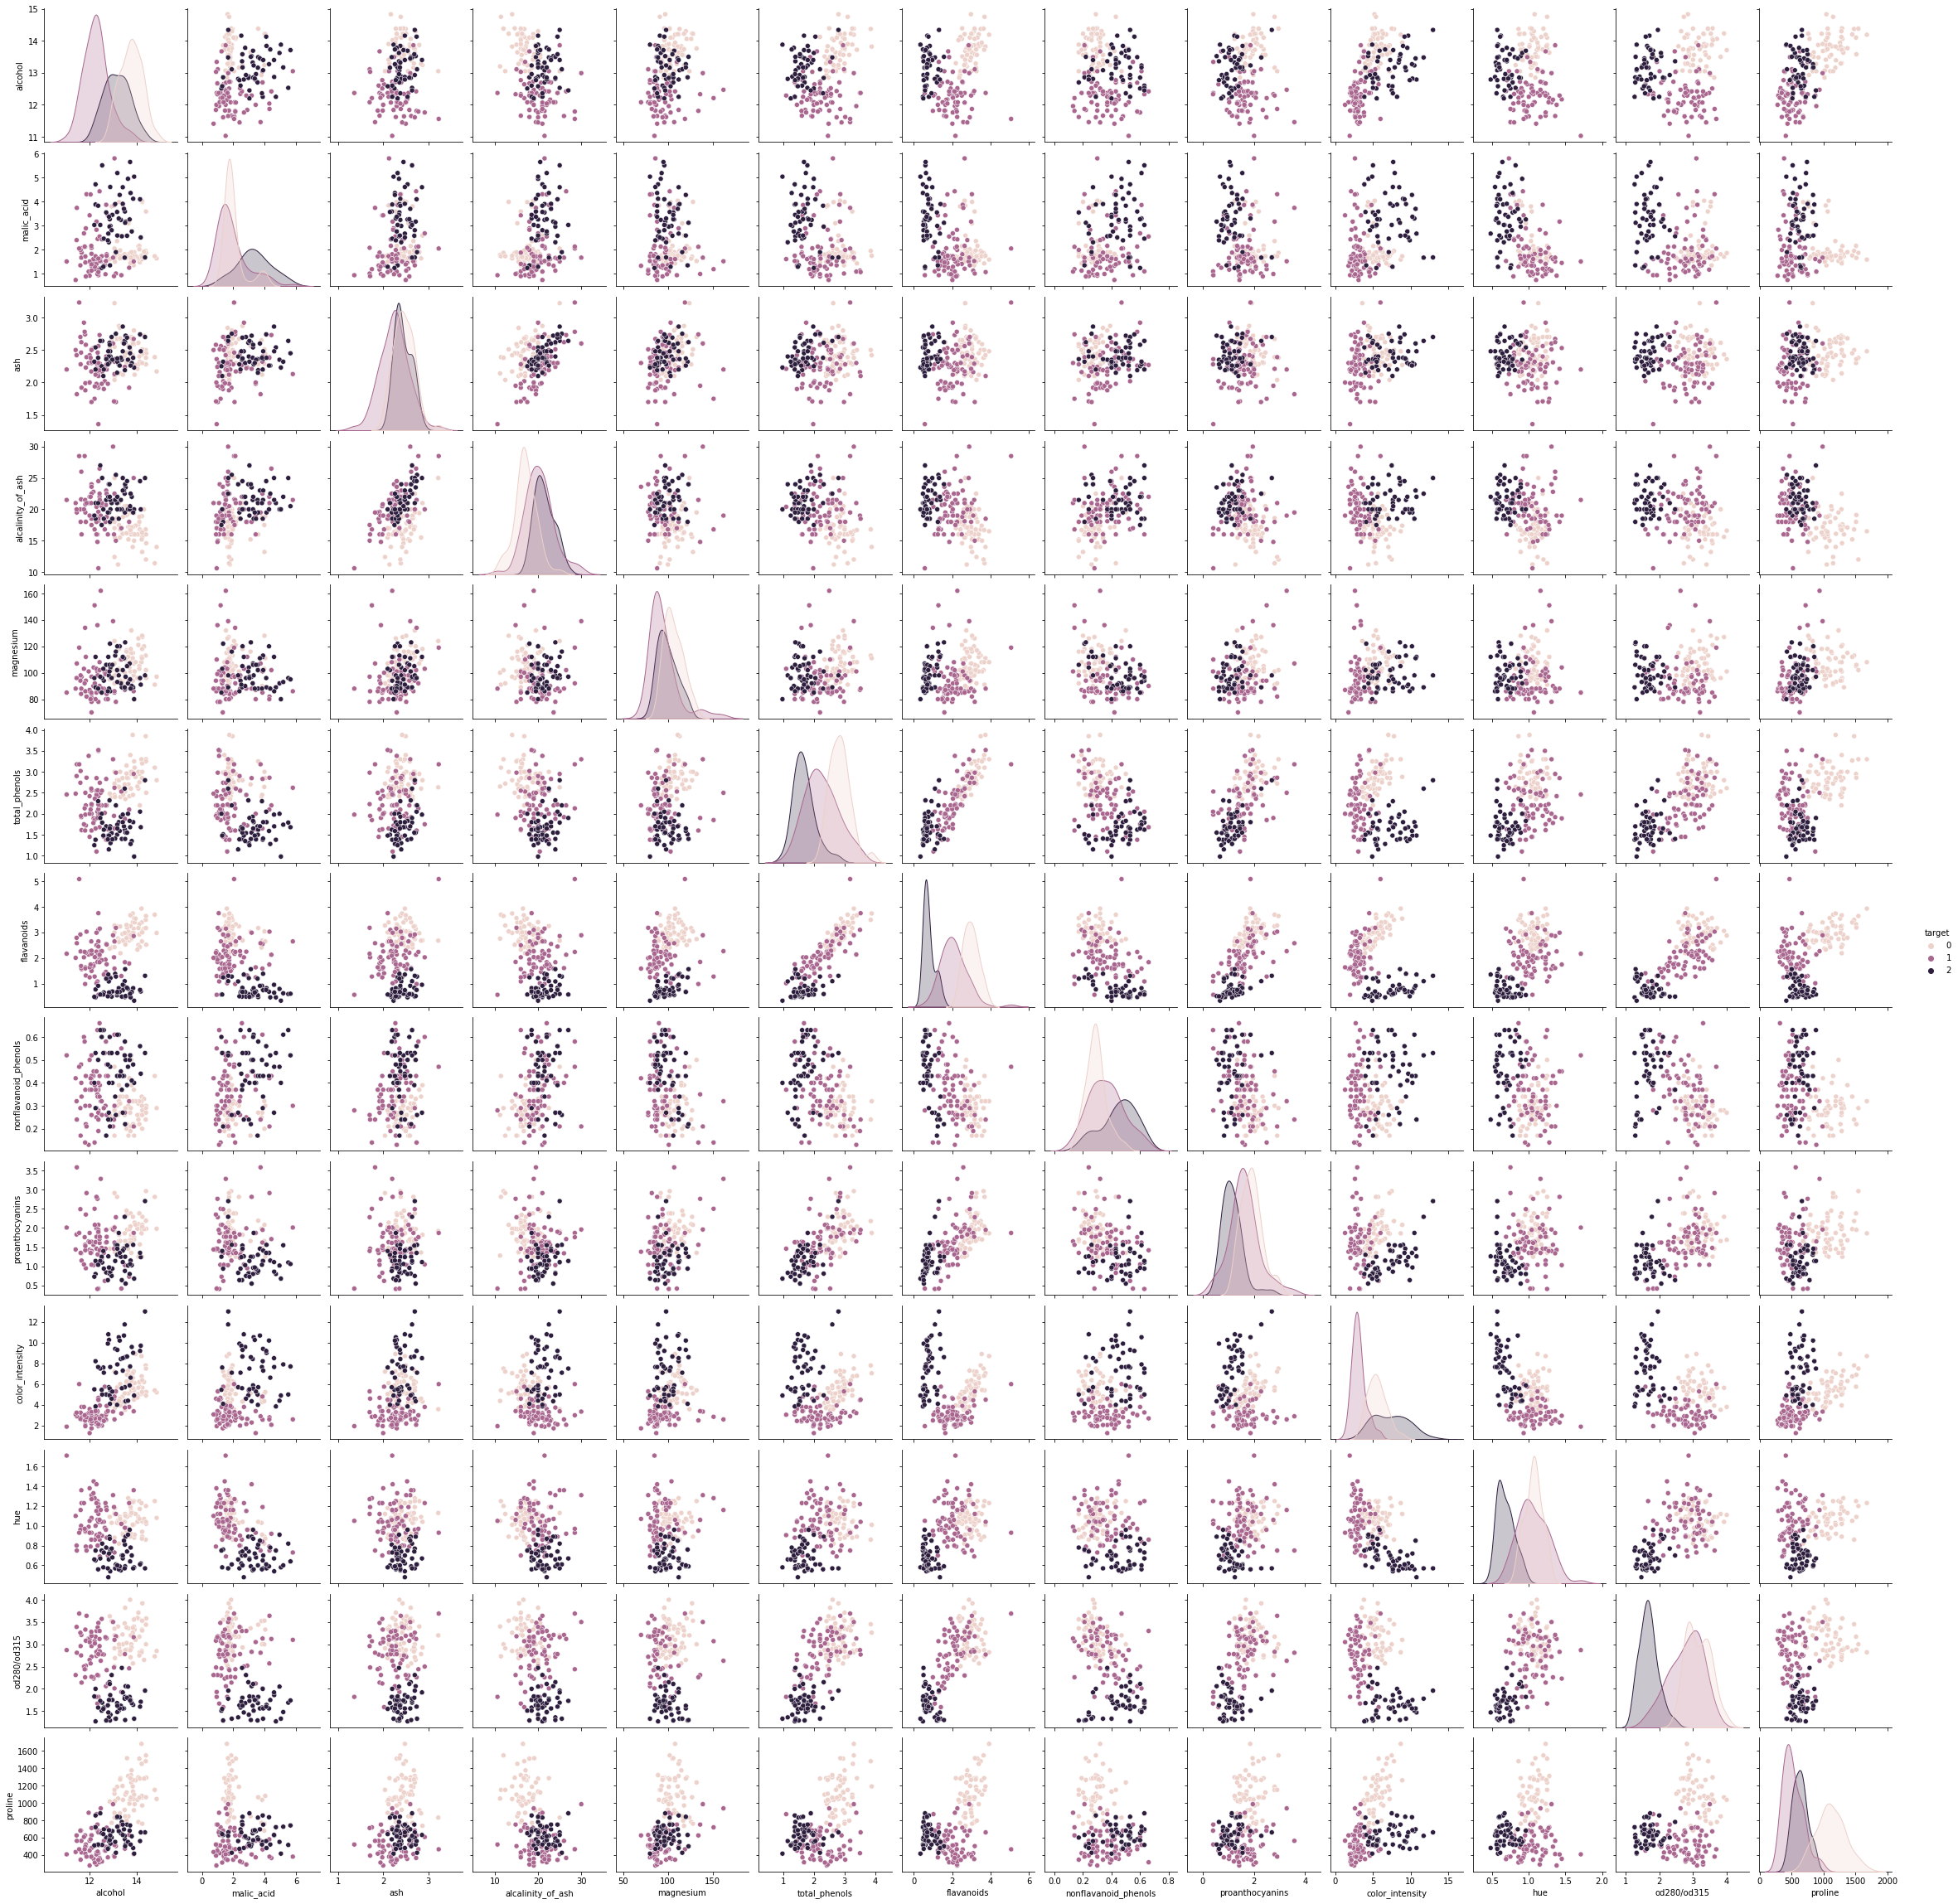

In [9]:
sns.pairplot(data=df, hue='target')
plt.savefig('PairPlot1.pdf')

In [9]:
y.skew()

target    0.107431
dtype: float64

## División en Entrenamiento/Prueba

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state = 123)

## Manejo de outliers en conjunto de entrenamiento

In [11]:
def BoxCox(columna, dataframe, lm=None):
    '''
    Función que toma el nombre de una columna perteneciente a un dataframe, realiza una transformación BoxCox 
    (el lambda se puede pasar como argumento opcional) y modifica el valor de esta columna por el valor que
    arroja la transformación. La función retorna un DataFrame con el valor del lambda usado y el sesgo antes
    y después de la transformación
    '''
    skp = dataframe[columna].skew()
    if type(lm) != type(None):
        bc_result = boxcox(dataframe[columna], lmbda=lm)
    else:
        bc_result = boxcox(dataframe[columna])
        lm = bc_result[1]
        bc_result = bc_result[0]
    resultado = pd.DataFrame([[skp, pd.DataFrame(bc_result,columns=[columna]).skew()[columna], lm]],columns=['Skew_Prev','Skew_Pos','Lambda'],index=[columna])
    return(resultado,bc_result)

In [12]:
def Identificar_y_transformar(data, to_bc=None, lm=None):
    '''
    Función que toma un dataframe, identifica las columnas que tienen sesgo mayor o igual a 0.5 y les realiza 
    una transformación BoxCox. Retorna un DataFrame lambda usado para cada columna, además del valor del sesgo
    antes y después de la transformación.
    '''
    if type(to_bc)==type(None):
        to_bc = data.columns[data.skew().abs()>=0.5]
        lambda_df = pd.DataFrame([])
        for i in to_bc:
            l, nd = BoxCox(i,data)
            lambda_df = pd.concat([lambda_df,l], axis=0)
            data[i]=nd
        return(lambda_df)
    else:
        lambda_df = pd.DataFrame([])
        for i in to_bc:
            l, nd = BoxCox(i,data, lm[i])
            lambda_df = pd.concat([lambda_df,l], axis=0)
            data[i]=nd
        return(lambda_df)

In [13]:
transformacion_train = Identificar_y_transformar(X_train)

In [14]:
transformacion_train

,Skew_Prev,Skew_Pos,Lambda
malic_acid,1.055641,0.038958,-0.351534
magnesium,1.274890,0.012844,-1.704072
nonflavanoid_phenols,0.508417,-0.013087,0.217184
color_intensity,0.677722,-0.021331,0.220933
proline,0.799726,0.010563,-0.096343


In [15]:
transformacion_test = Identificar_y_transformar(X_test, to_bc=transformacion_train['Lambda'].index, lm=transformacion_train['Lambda'])

In [16]:
transformacion_test

,Skew_Prev,Skew_Pos,Lambda
malic_acid,1.045577,-0.137213,-0.351534
magnesium,0.874936,-0.009848,-1.704072
nonflavanoid_phenols,0.360343,-0.108212,0.217184
color_intensity,1.217335,0.462128,0.220933
proline,0.654597,0.024510,-0.096343


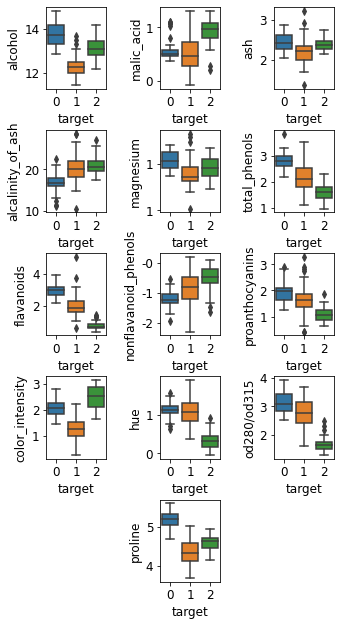

In [17]:
df_train = pd.concat([X_train,y_train],axis=1)
name='Boxplot_train.pdf'
BoxPlot(df_train,name)

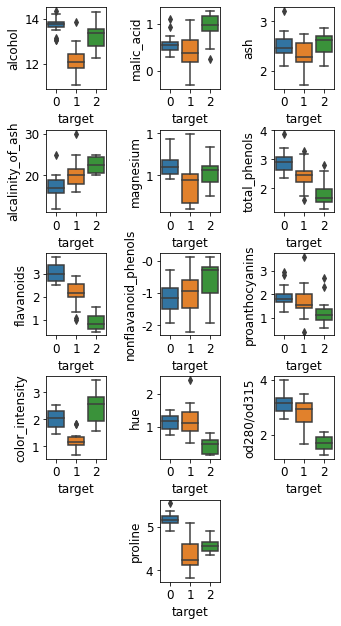

In [18]:
df_test = pd.concat([X_test,y_test],axis=1)
name='Boxplot_test.pdf'
BoxPlot(df_test,name)

## Entrenamiento

In [214]:
def evaluate_metrics(yt, yp, Xt, model):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    results_pos['auc'] = roc_auc_score(yt, model.predict_proba(Xt), multi_class='ovr',average=None)
    return results_pos

In [217]:
def Confussion(y_test, l1_preds, ax, nombre):
    cf = confusion_matrix(y_test, l1_preds)
    sns.heatmap(cf, annot=True, fmt="d", ax=ax)
    ax.set(title="Confusion Matrix");
    plt.savefig(nombre)
    plt.show()

In [206]:
def get_feature_coefs(regression_model, label_index, columns):
    coef_dict = {}
    for coef, feat in zip(regression_model.best_estimator_[1].coef_[label_index, :], columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

# Visualize coefficients
def visualize_coefs(coef_dict, nombre, Titulo, aspect):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title(Titulo)
    fig.subplots_adjust(**aspect)
    plt.savefig(nombre)
    plt.show()

### Logistic regression

In [23]:
from sklearn.pipeline import Pipeline

In [42]:
estimator_LR_L2 = Pipeline([("scaler", StandardScaler()),
        ("Logistic_Regression_L2", LogisticRegression(penalty='l2', random_state=777, solver='liblinear'))])   
estimator_LR_L1 = Pipeline([("scaler", StandardScaler()),
        ("Logistic_Regression_L1", LogisticRegression(penalty='l1', random_state=777, solver='liblinear'))])

params_LR_L1 = {'Logistic_Regression_L1__C': np.logspace(-1, 3, 5)}
params_LR_L2 = {'Logistic_Regression_L2__C': np.logspace(-1, 3, 5)}

In [62]:
grid_L1 = GridSearchCV(estimator_LR_L1, params_LR_L1, cv=4)
grid_L2 = GridSearchCV(estimator_LR_L2, params_LR_L2, cv=4)
grid_L1.fit(X_train, y_train);
grid_L2.fit(X_train, y_train);
grid_L1.best_score_>grid_L2.best_score_

True

In [232]:
grid_L1.best_params_

{'Logistic_Regression_L1__C': 10.0}

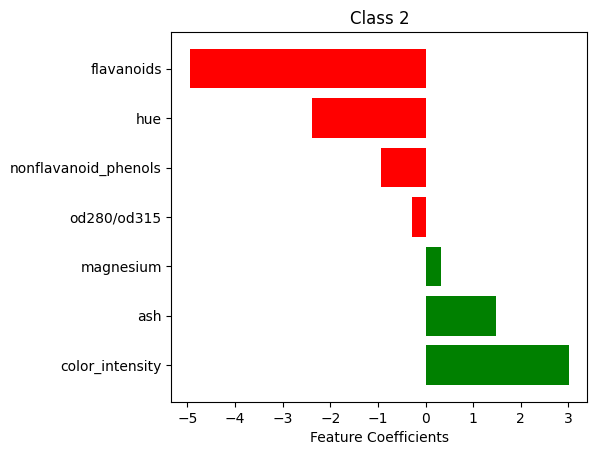

In [213]:
i=2
coef_dict_LR = get_feature_coefs(grid_L1, i, feature_names)
visualize_coefs(coef_dict_LR, 'FI_'+str(i)+'.pdf', "Class "+str(i), {'left':0.25})

In [215]:
pd.DataFrame(evaluate_metrics(y_test, grid_L1.predict(X_test),X_test,grid_L1)).T

,0,1,2
accuracy,0.981481,0.981481,0.981481
recall,1.000000,0.952381,1.000000
precision,1.000000,1.000000,0.937500
f1score,1.000000,0.975610,0.967742
auc,1.000000,1.000000,1.000000


In [220]:
pd.DataFrame(evaluate_metrics(y_test, grid_L1.predict(X_test),X_test,grid_L1)).mean()

accuracy     0.981481
recall       0.984127
precision    0.979167
f1score      0.981117
auc          1.000000
dtype: float64

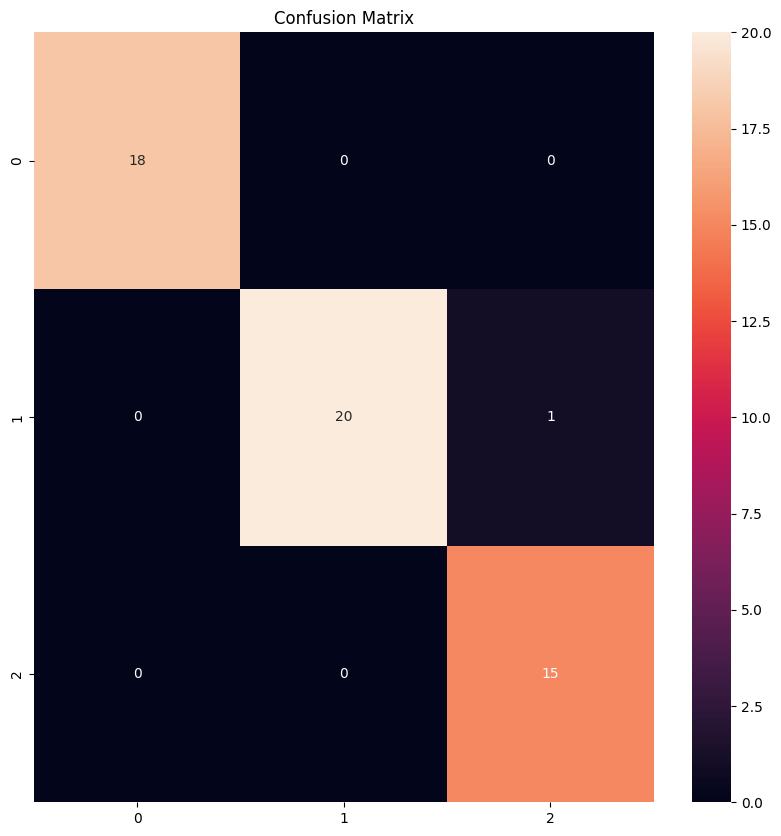

In [218]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10,10)
Confussion(y_test, grid_L1.predict(X_test), ax, "Confussion_LR.pdf")


### KNN

In [134]:
estimator_KNN = Pipeline([("scaler", StandardScaler()),
        ("KNN", KNeighborsClassifier())])   

params_KNN = {'KNN__n_neighbors': np.linspace(1, 40, 40).astype(int)}

In [136]:
grid_KNN = GridSearchCV(estimator_KNN, params_KNN, cv=4)
grid_KNN.fit(X_train, y_train);
grid_KNN.best_params_

{'KNN__n_neighbors': 5}

In [137]:
grid_KNN.best_score_

0.967741935483871

In [216]:
pd.DataFrame(evaluate_metrics(y_test, grid_KNN.predict(X_test),X_test,grid_KNN)).T

,0,1,2
accuracy,0.907407,0.907407,0.907407
recall,1.000000,0.761905,1.000000
precision,0.818182,1.000000,0.937500
f1score,0.900000,0.864865,0.967742
auc,0.984568,0.969697,1.000000


In [219]:
pd.DataFrame(evaluate_metrics(y_test, grid_KNN.predict(X_test),X_test,grid_KNN)).mean()

accuracy     0.907407
recall       0.920635
precision    0.918561
f1score      0.910869
auc          0.984755
dtype: float64

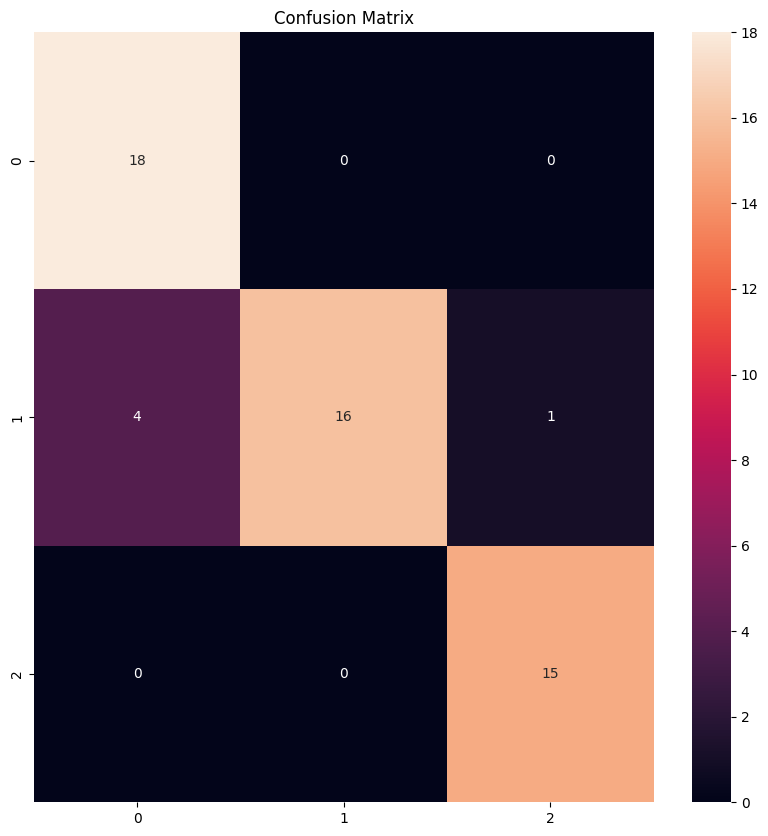

In [221]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10,10)
Confussion(y_test, grid_KNN.predict(X_test), ax, 'Confusion_KNN.pdf')

### SVM

### Decision Trees

In [145]:
from sklearn.tree import DecisionTreeClassifier

In [222]:
def plot_decision_tree(model, feature_names, nombre):
    plt.subplots(figsize=(25, 20)) 
    tree.plot_tree(model, 
                       feature_names=feature_names,  
                       filled=True)
    plt.savefig(nombre)
    plt.show()

In [170]:
params_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [3, 5, 7]
}
model = DecisionTreeClassifier(random_state=1234)
grid_search = GridSearchCV(estimator = model, 
                        param_grid = params_grid, 
                        cv = 5, verbose = 1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3}

In [171]:
grid_search.best_score_

0.9193333333333333

In [224]:
pd.DataFrame(evaluate_metrics(y_test, grid_search.predict(X_test),X_test, grid_search)).T

,0,1,2
accuracy,0.981481,0.981481,0.981481
recall,1.000000,1.000000,0.933333
precision,1.000000,0.954545,1.000000
f1score,1.000000,0.976744,0.965517
auc,1.000000,0.982684,0.966667


In [225]:
pd.DataFrame(evaluate_metrics(y_test, grid_search.predict(X_test),X_test, grid_search)).mean()

accuracy     0.981481
recall       0.977778
precision    0.984848
f1score      0.980754
auc          0.983117
dtype: float64

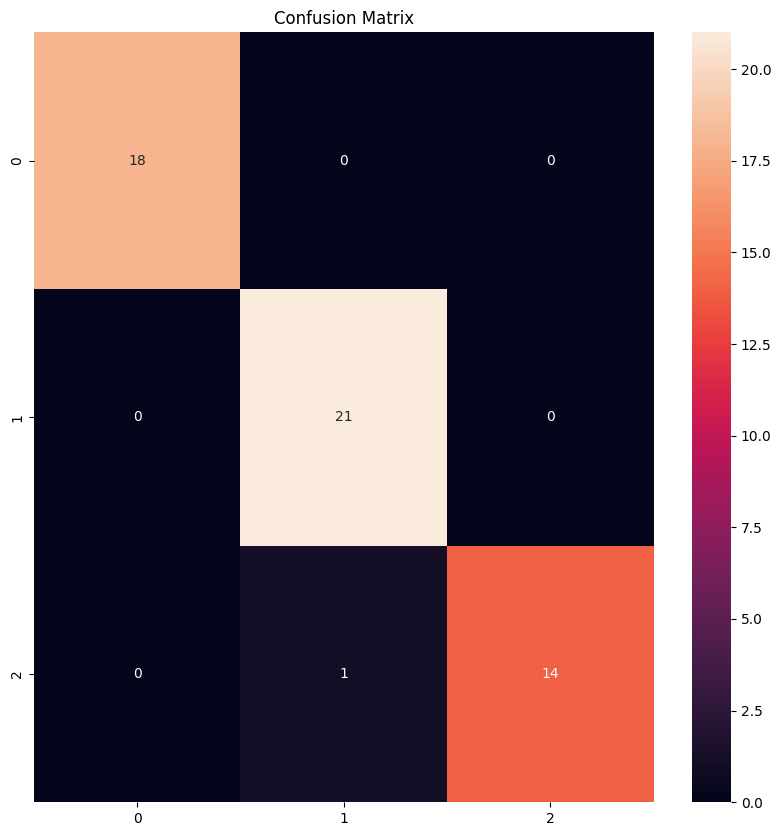

In [226]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10,10)
Confussion(y_test, grid_search.predict(X_test), ax, 'Confussion_Tree.pdf')

In [177]:
!pip install -U scikit-learn


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


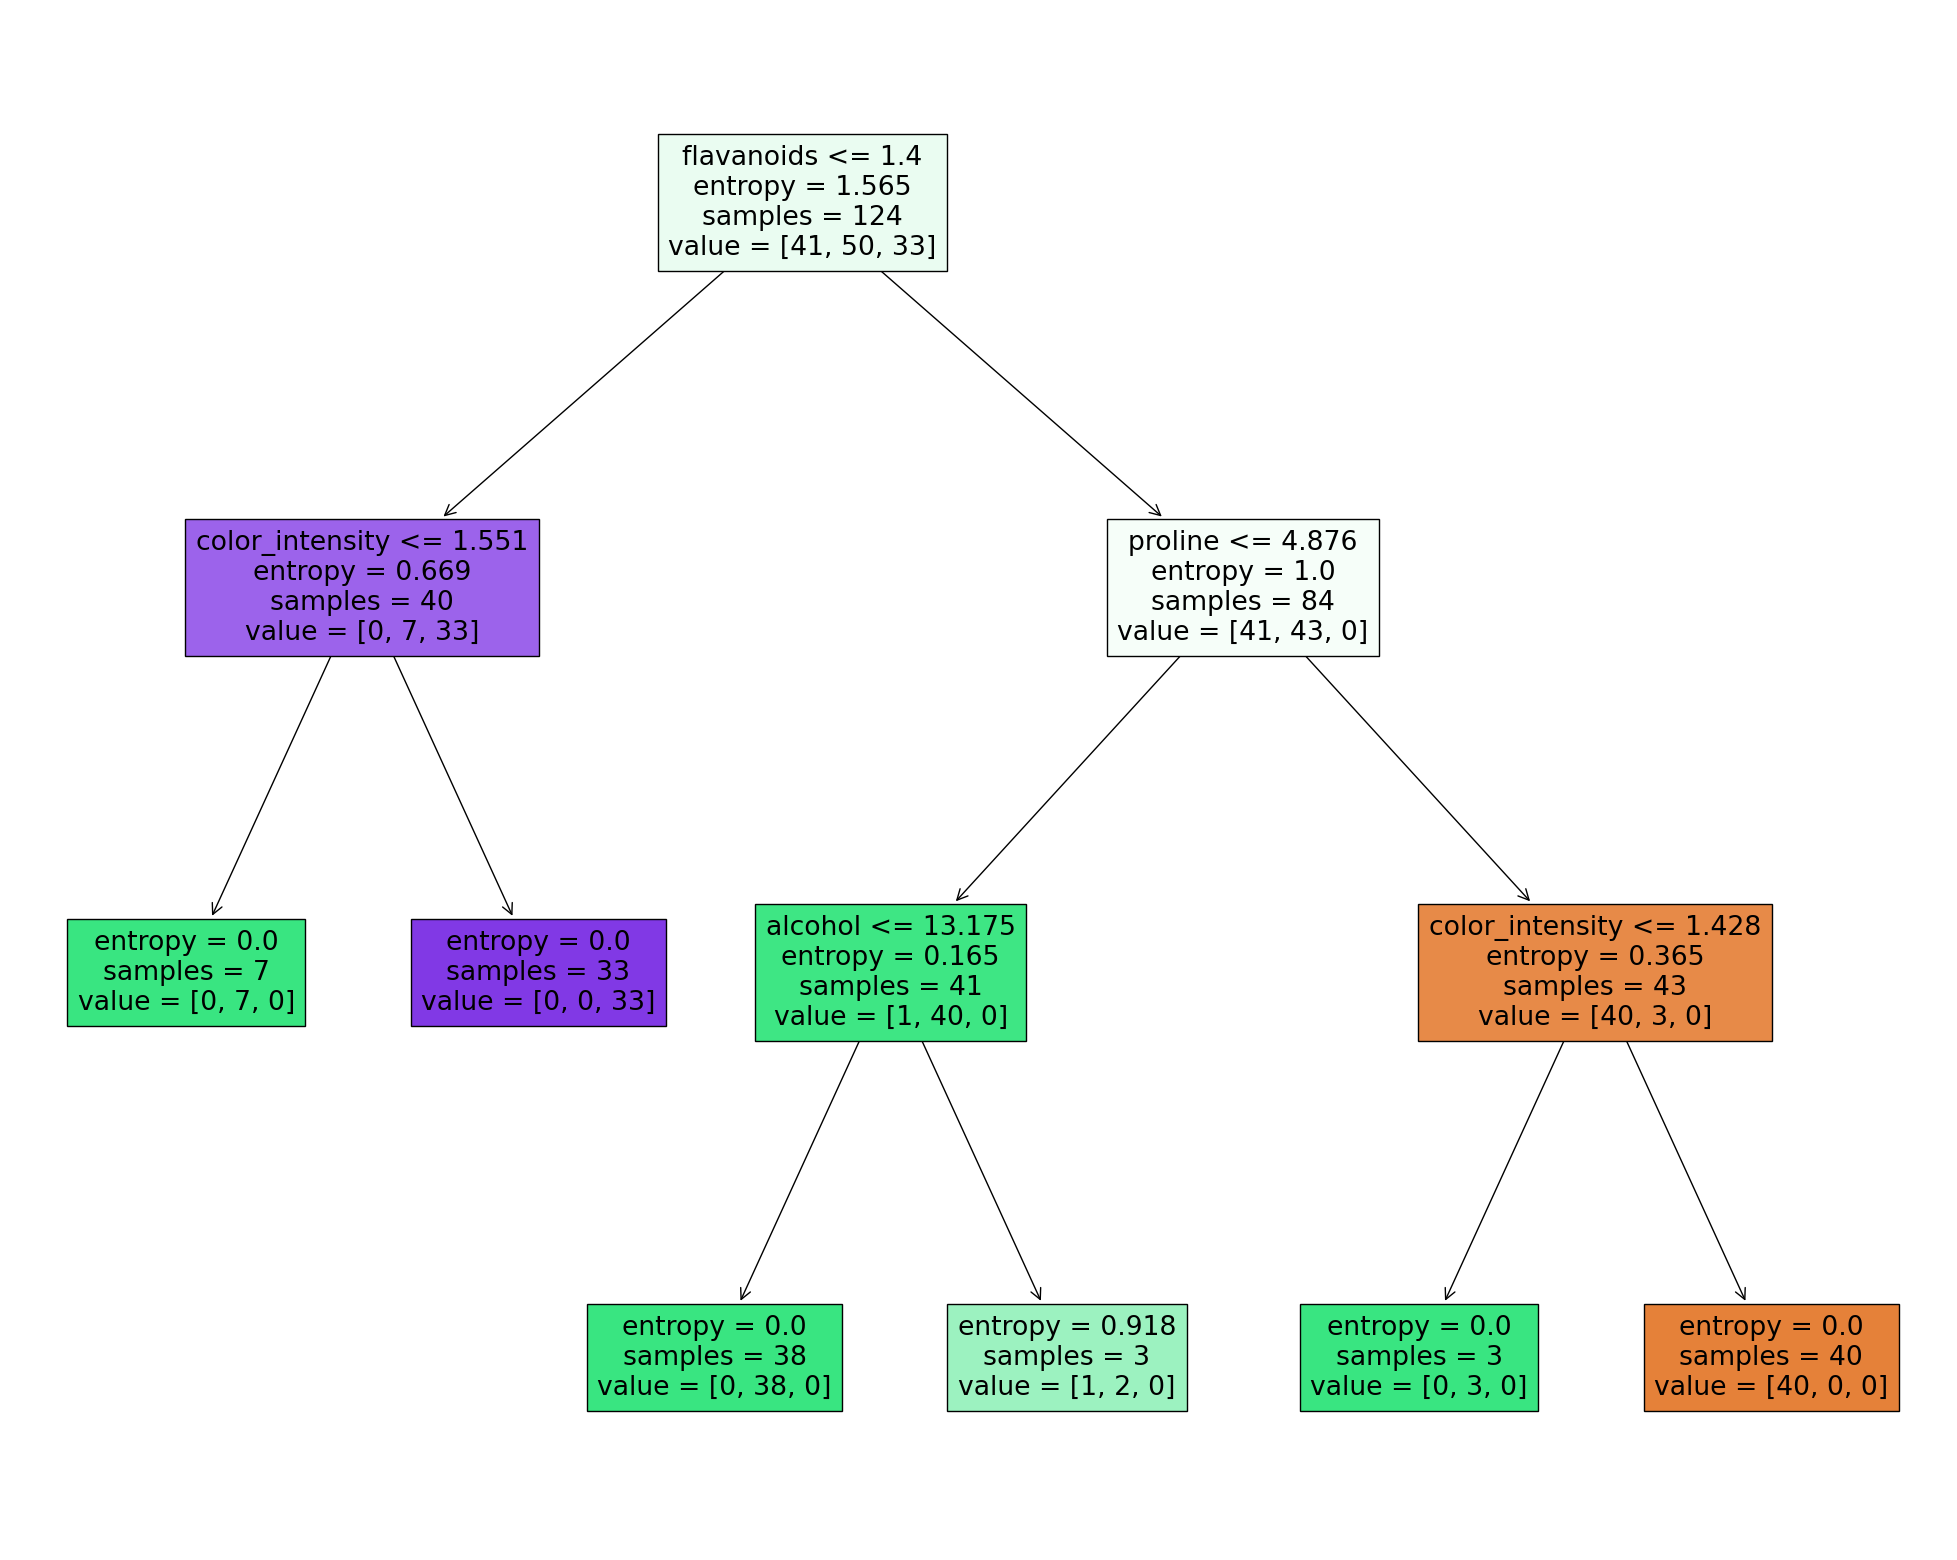

In [227]:
from sklearn import tree
custom_model = DecisionTreeClassifier(**grid_search.best_params_)
custom_model.fit(X_train, y_train)
preds = custom_model.predict(X_test)
# Plot the decision tree
plot_decision_tree(custom_model, feature_names, 'Tree.pdf')

### Random Forest

In [189]:
from sklearn.ensemble import RandomForestClassifier

In [190]:
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}
model = RandomForestClassifier()
RF = GridSearchCV(estimator=model, param_grid=param_grid,scoring='accuracy')
RF.fit(X_train, y_train)
RF.best_score_

1.0

In [191]:
RF.best_params_

{'max_depth': 3, 'max_features': 'auto', 'n_estimators': 23}

In [229]:
pd.DataFrame(evaluate_metrics(y_test, RF.predict(X_test),X_test, RF)).T

,0,1,2
accuracy,0.981481,0.981481,0.981481
recall,1.000000,0.952381,1.000000
precision,0.947368,1.000000,1.000000
f1score,0.972973,0.975610,1.000000
auc,0.998457,0.997114,1.000000


In [230]:
pd.DataFrame(evaluate_metrics(y_test, RF.predict(X_test),X_test, RF)).mean()

accuracy     0.981481
recall       0.984127
precision    0.982456
f1score      0.982861
auc          0.998524
dtype: float64

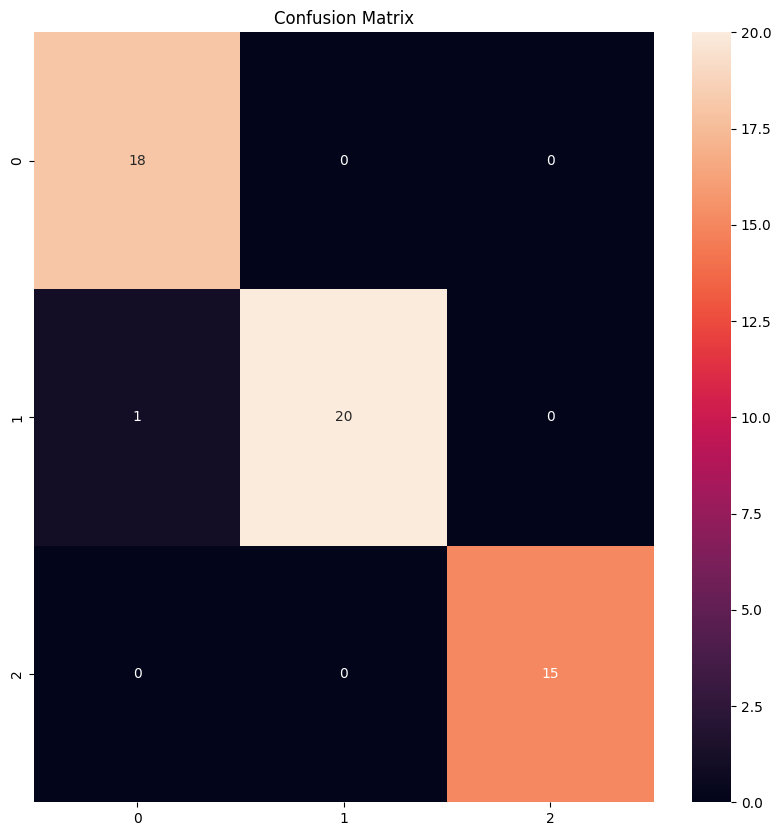

In [231]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10,10)
Confussion(y_test, RF.predict(X_test), ax, 'Random_Forest.pdf')